<a href="https://colab.research.google.com/github/maschu09/mless/blob/main/time_series_forecasting/2_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Load the Raw data.

Now that we have a basic statistical understanding of the data and have normalized it, let's see in this notebook some timeseries characteristics of the data(seasonality, stationarity, etc.) we have that will enable us to in-turn choose which model to use.

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt

## Raw data csv is also made available for the select stations in URL:
url = "https://drive.google.com/uc?export=download&id=1cmTTWY3f18SikgRBcZzhtFswIf7XwPJq"
dataframes = pd.read_csv(url,parse_dates=["datetime"])
## Else if using local files:
# dataframes = pd.read_csv(os.path.join(TIMESERIES_DATA_DIR, "raw_data.csv"))
dataframes.head()

,longitude,latitude,station_code,datetime,temp
0,7.567796,47.819182,DEBW073,1997-01-01 00:00:00+00:00,-10.0
1,7.567796,47.819182,DEBW073,1997-01-01 01:00:00+00:00,-11.0
2,7.567796,47.819182,DEBW073,1997-01-01 02:00:00+00:00,-11.0
3,7.567796,47.819182,DEBW073,1997-01-01 03:00:00+00:00,-12.0
4,7.567796,47.819182,DEBW073,1997-01-01 04:00:00+00:00,-12.0


In [3]:
variable_columns = ["temp"]
dataframes.shape

(579480, 5)

In [4]:
!pip install seaborn matplotlib statsmodels scikit-learn

In [6]:
station_sample = 'DENW094'
variable_sample = 'temp'
# Filter data for the selected samples
df_station = dataframes[dataframes["station_code"] == station_sample]

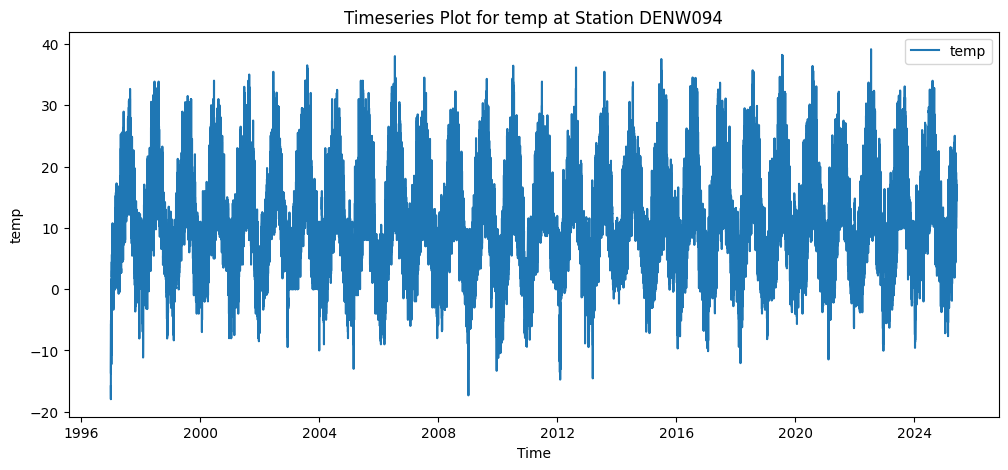

In [14]:
dataframes.head()

## Basic statistical data analysis

Before we start building statistical or ML models we should always inspect the statistical properties of our data. Since we are primarily interested in forecasting, we will focus on a couple of metrics to evaluate auto-correlation, stationarity, or heteroskedacity of the data. Trend analysis can also be relevant if there are bias drifts in the data.

😈 **Question 1:** What is the difference between analyzing statistical features and timeseries patterns?


In [17]:
stats = ['min', 'max', 'mean', 'std', 'var',
    ('5th_percentile', lambda x: x.quantile(0.05)),
    ('10th_percentile', lambda x: x.quantile(0.10)),
    ('25th_percentile', lambda x: x.quantile(0.25)),
    ('50th_percentile', lambda x: x.quantile(0.50)), #(median)
    ('75th_percentile', lambda x: x.quantile(0.75)),
    ('90th_percentile', lambda x: x.quantile(0.90)),
    ('95th_percentile', lambda x: x.quantile(0.95)) ]

# Get all columns except the specified exceptions
excl = ['station_code', 'datetime', 'latitude', 'longitude']
variable_columns = [col for col in dataframes.columns if col not in excl]

agg_dict = {col: stats for col in variable_columns}

# Group the dataframe by 'station_code' and aggregate the statistics
grouped = dataframes.groupby('station_code').agg(agg_dict)

# Display the aggregated statistics
for agg_func in ['min', 'max', 'mean', 'std']:
    print(f"\n{agg_func.upper()}")
    agg_view = grouped.xs(agg_func, axis=1, level=1)
    display(agg_view)



MIN


,temp
station_code,
DEBW073,-14.50
DEHE020,-18.20
DENW094,-17.95



MAX


,temp
station_code,
DEBW073,37.300000
DEHE020,38.842102
DENW094,39.126000



MEAN


,temp
station_code,
DEBW073,11.009674
DEHE020,10.719074
DENW094,10.565025



STD


,temp
station_code,
DEBW073,8.172790
DEHE020,8.082949
DENW094,7.278911


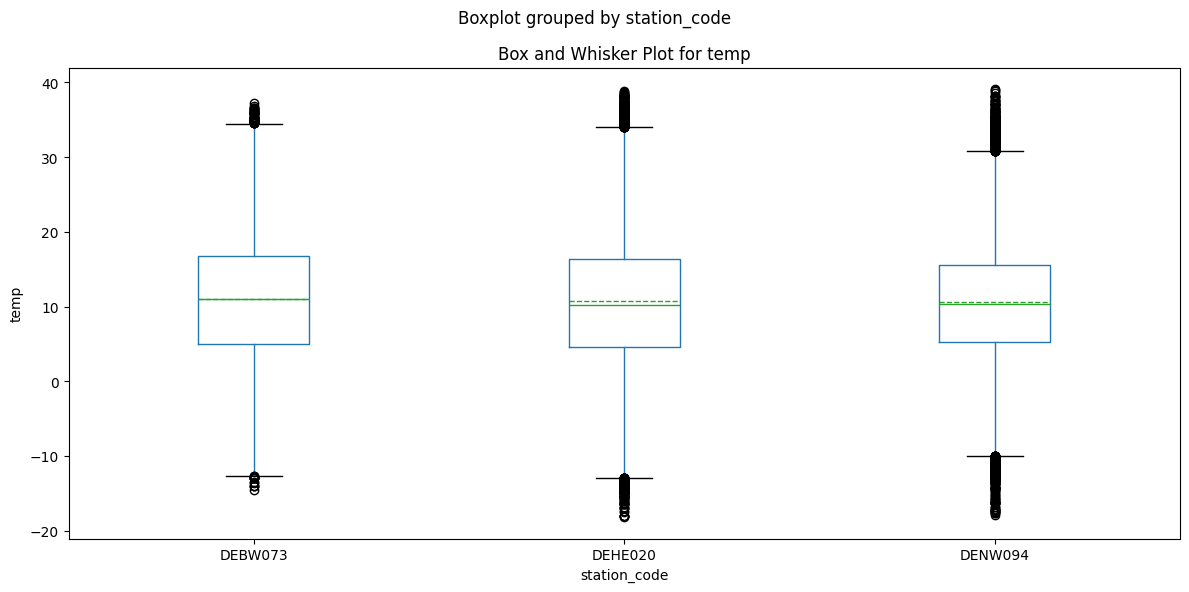

In [34]:
# generate box and whisker plots for each variable using the grouped dataset
# Create a figure with one subplot per variable
n_vars = len(variable_columns)
fig, axes = plt.subplots(len(variable_columns), 1, figsize=(12, 6*n_vars))
axes = [axes] if n_vars == 1 else axes

# Iterate over each variable and plot its box plot
for i, (col, ax) in enumerate(zip(variable_columns, axes)):
    # Plot the box plot for the current variable
    dataframes.boxplot(column=col, by='station_code', ax=ax, showmeans=True, meanline=True)

    # Customize the plot
    ax.set_title(f'Box and Whisker Plot for {col}')
    ax.set_ylabel(col)
    ax.grid(False)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

## Visualize the time series before further analysis


In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [43]:
stations_in_dataframe = dataframes['station_code'].unique()
print(f"Available stations: {stations_in_dataframe}")
n_stations = len(stations_in_dataframe)

variable_sample = 'temp'

Available stations: ['DEBW073' 'DEHE020' 'DENW094']


#### Visualizing initial data before trends
 Select a station and variable for analysis. In this exercise we focus on temperature. If you are curious, try out Ozone (o3) or any other variable from the TOAR database.

😈 **Task 1 (optional):** Go back to the data loader notebook and retrieve data of at least 2 variables. Modify the code below to plot and analyze the nehaviour of all variables in the dataframe.

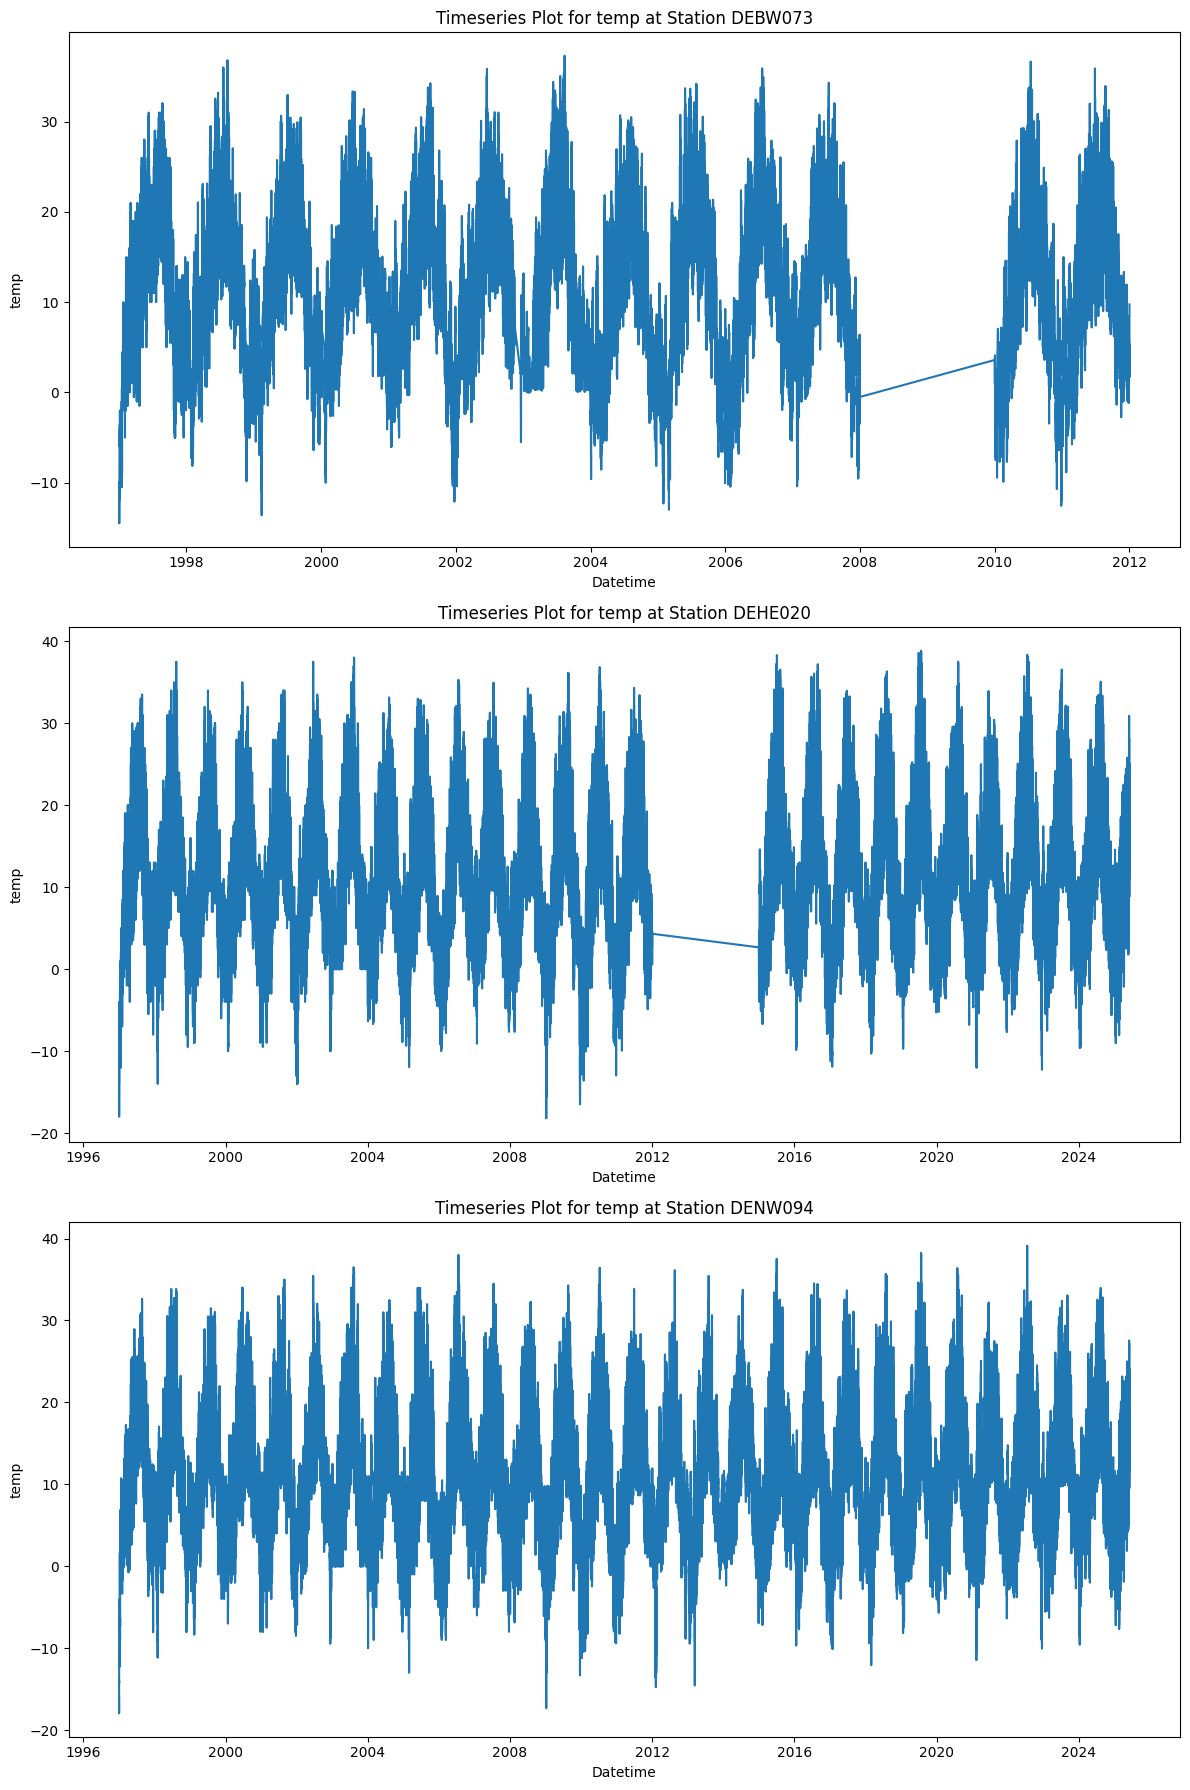

In [47]:
fig, axes = plt.subplots(n_stations, figsize=(12, 6*n_stations))
axes = [axes] if n_stations == 1 else axes

# loop over the stations and show all timeseries
for i, (grp, ax) in enumerate(zip(stations_in_dataframe, axes)):
    # Filter data for the selected samples
    df_station = dataframes[dataframes["station_code"] == grp]
    ax.plot(df_station["datetime"], df_station[variable_sample], label=variable_sample)
    # Customize the plot
    ax.set_title(f"Timeseries Plot for {variable_sample} at Station {grp}")
    ax.set_xlabel("Datetime")
    ax.set_ylabel(variable_sample)
    ax.grid(False)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()


### **Timeseries Data Analysis and Anomaly Detection**
Since we know the data is a timeseries, we can analyse for seasonality, trends, and anomalies. such as:
- **Temporal Seasonality:** Decomposing the time series into trend, seasonality, and residuals.
- **Rolling Statistics:** Checking for stationarity.
- **Autocorrelation (ACF, PACF):** Identifying patterns in the data.
- **Anomaly Detection:** Using Z-score and visualizing anamolies.


😈 **Question 2:** How do stationarity and autocorrelation influence the selection of an appropriate ML model?


#### Temporal Seasonality
Here is a simple sample seasonal decomposition, you can experiment with modifying the period and other seasonalities

😈 **Task 2:** Change the `period` parameter. What happens to the seasonality and trend components?


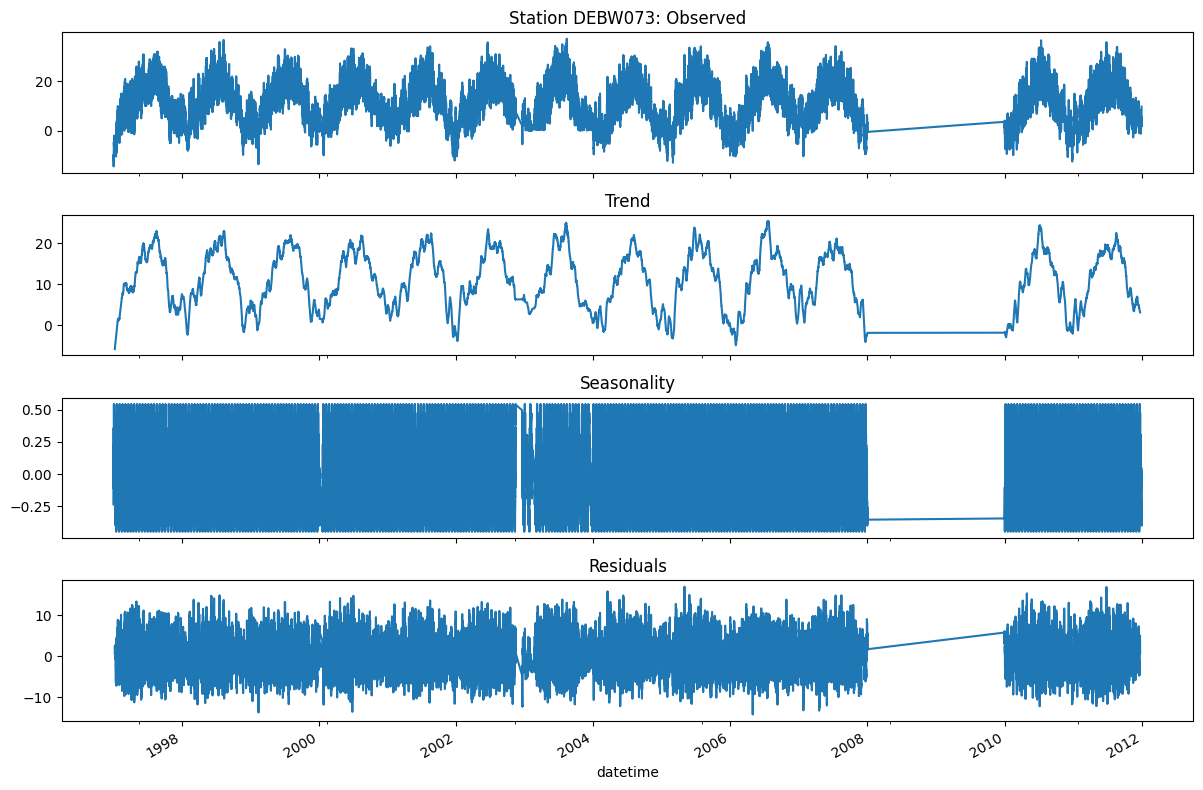

In [56]:
# Concentrate on one of the stations to make things easier for now
this = stations_in_dataframe[0]
df_station = dataframes[dataframes["station_code"] == this]

# Decompose the time series
decomposition = seasonal_decompose(df_station.set_index("datetime")[variable_sample], period=365, model='additive')

# Plot the decomposition
fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
decomposition.observed.plot(ax=axes[0], title=f"Station {this}: Observed")
decomposition.trend.plot(ax=axes[1], title="Trend")
decomposition.seasonal.plot(ax=axes[2], title="Seasonality")
decomposition.resid.plot(ax=axes[3], title="Residuals")
plt.tight_layout()
plt.show()

#### Rolling Statistics Analysis

Below is a sample function using adfuller method from stats_model package used for visualizing stationarity in the o3 of the sample station


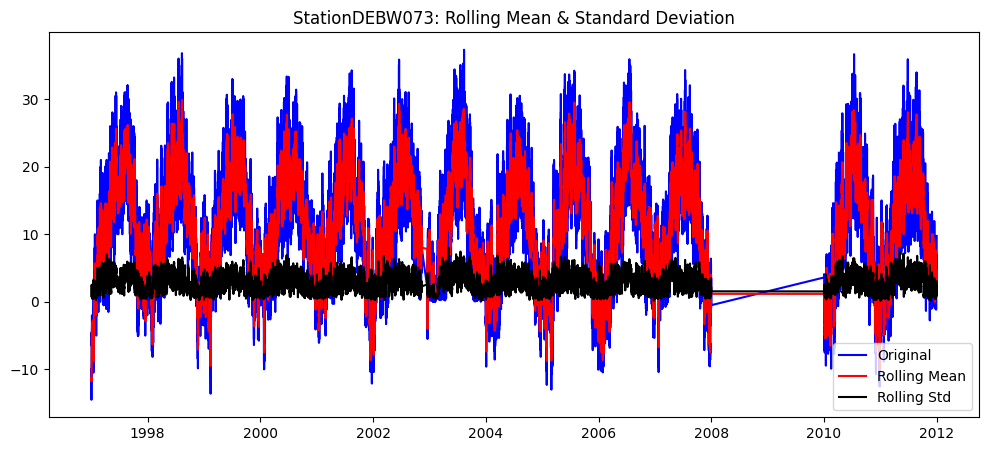

In [57]:
def plot_stationarity(timeseries):
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()

    plt.figure(figsize=(12,5))
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend()
    plt.title(f"Station{this}: Rolling Mean & Standard Deviation")
    plt.show()


plot_stationarity(df_station.set_index("datetime")[variable_sample])

Below snippet uses ADF ([Augmented Dickey-Fuller test](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test)) checks if a time series is stationary (constant mean and variance over time). In Moving Average models, p (AutoRegressive lags), d (number of differences for stationarity), and q (Moving Average lags) help capture trends and fluctuations—stationarity ensures that past patterns remain predictive for future values. AIC (Akaike Information Criterion) measures the goodness of fit of a model while penalizing complexity. In MA models, it helps select the best combination of p, d, q by balancing model accuracy and simplicity—lower AIC values indicate a better model as illustrated later on.

😈 **Question 3:** Why is low AIC important in model selection?

😈 **Task 3:** Apply grid search for AIC using different `p`, `d`, `q` combinations.


In [58]:
adf_test = adfuller(df_station.set_index("datetime")[variable_sample].dropna(), autolag='AIC')
print(f"Station {this}:\n")
print(f"ADF Test Statistic: {adf_test[0]}")
print(f"P-Value: {adf_test[1]}")
print("Critical Values:", adf_test[4])
print("Stationary at 95% confidence" if adf_test[1] < 0.05 else "Not Stationary")

Station DEBW073:

ADF Test Statistic: -9.69362786805326
P-Value: 1.1193265509788387e-16
Critical Values: {'1%': np.float64(-3.4304090102011267), '5%': np.float64(-2.861566081612447), '10%': np.float64(-2.5667838823247604)}
Stationary at 95% confidence


#### Correlation analysis

*Auto correlation* measures the dependence of the variable value at a given point in time on earlier values (see Markov process).

😈 **Task 4:** Inform yourself about auto correlation and partial auto correlation.


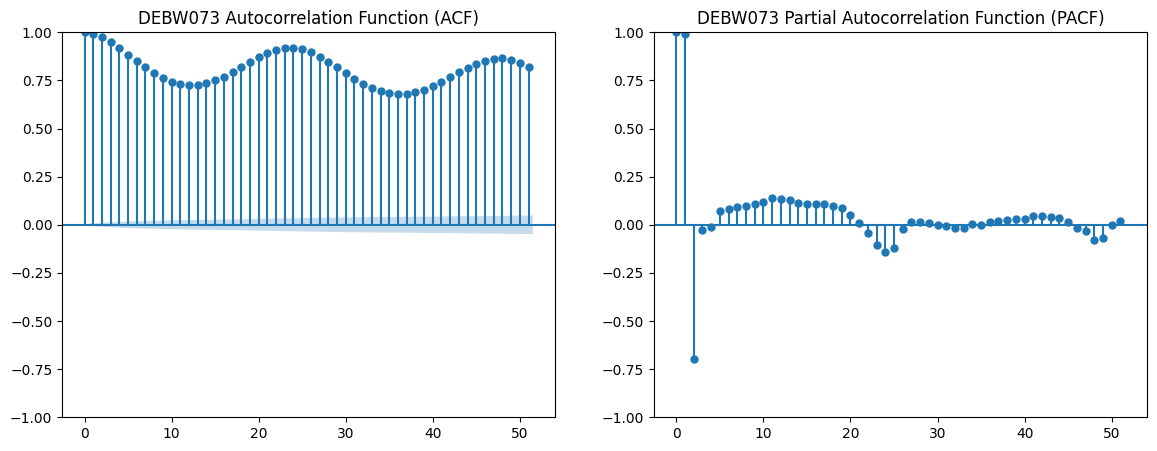

In [59]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
plot_acf(df_station.set_index("datetime")[variable_sample].dropna(), ax=ax[0])
plot_pacf(df_station.set_index("datetime")[variable_sample].dropna(), ax=ax[1])
ax[0].set_title(f"{this} Autocorrelation Function (ACF)")
ax[1].set_title(f"{this} Partial Autocorrelation Function (PACF)")
plt.show()

### Anomaly detection using Z-score

Z-score ($Z = (x-\mu)/\sigma$) is the standard normalisation applied to datasets when feeding them into ML models or statistical models.

You can also use Z-score to detect outliers and remove or cap them. The basic assumption behind this approach is that the data are (almost) Gaussian distributed and stationary. Typically, a threshold value of 3 (i.e., $3 \sigma$ or "outside the range of 99% of the data") or higher is used.

😈 **Question 4:** What is the danger of using Z-scores to eliminate outliers? Do you know better approaches?

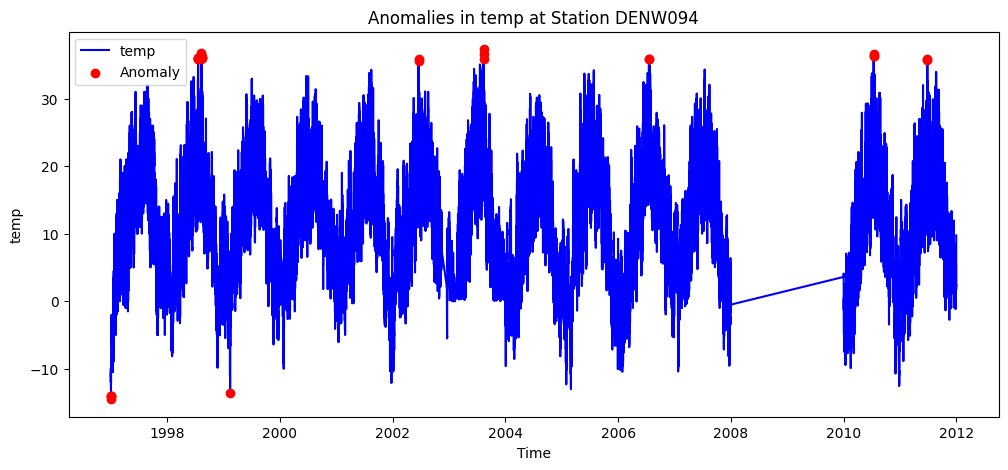

In [61]:
from scipy.stats import zscore

# Compute Z-scores
df_station["zscore"] = zscore(df_station[variable_sample], nan_policy='omit')

# Sample threshold for anomalies (|Z-score| > 3)
threshold = 3
df_anomalies = df_station[np.abs(df_station["zscore"]) > threshold]

# Plot anomalies
plt.figure(figsize=(12, 5))
plt.plot(df_station["datetime"], df_station[variable_sample], label=variable_sample, color='blue')
plt.scatter(df_anomalies["datetime"], df_anomalies[variable_sample], color='red', label="Anomaly", zorder=3)
plt.xlabel("Time")
plt.ylabel(variable_sample)
plt.title(f"Anomalies in {variable_sample} at Station {station_sample}")
plt.legend()
plt.show()
